## Intalacion de Librerias, Imports y Funciones

In [ ]:
!pip install ptflops
!pip install torchinfo

In [ ]:
import os
import sys
import time
import math
import copy
from math import ceil
from datetime import datetime
from functools import partial
from typing import Any, Callable, List, Optional, Sequence, Union
from dataclasses import dataclass
from io import StringIO

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from ptflops import get_model_complexity_info
from torchinfo import summary
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

def _make_divisible(v, divisor, min_value):

    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def adjust_depth(num_layers, depth_mult):
    return int(ceil(num_layers * depth_mult))

class Logger:
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, 'a', encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        self.log.flush()

    def flush(self):
        self.terminal.flush()
        self.log.flush()



Mounted at /content/drive


### Descarga MNIST, Transformaciones y Funciones para Entrenamiento

In [ ]:
# Ajustar las transformaciones para MNIST (imágenes en escala de grises)
mean = (0.1307,) * 3
std = (0.3081,) * 3

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar a 32x32 para mantener compatibilidad
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convertir a 3 canales
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convertir a 3 canales
    transforms.Normalize(mean, std)
])

# Cargar MNIST
train_mnist = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    download=True,
    transform=train_transform
)

test_mnist = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    download=True,
    transform=val_test_transform
)

# Dividir el conjunto de entrenamiento
train_size = int(0.9 * len(train_mnist))
val_size = len(train_mnist) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_mnist, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Actualizar las clases
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')



def show_gradients_EfficientNet(model, epoch):
    # Crear directorio para los gradientes si no existe
    gradients_dir = os.path.join(checkpoint_dir, 'gradients')
    epoch_dir = os.path.join(gradients_dir, f'epoch_{epoch}')
    os.makedirs(epoch_dir, exist_ok=True)

    layers_to_show = ['features.0.0.weight', 'features.5.0.block.0.0.weight', 'classifier.1.weight']
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")

            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')

            # Guardar el gráfico en lugar de mostrarlo
            filename = f'{name.replace(".", "_")}.png'
            plt.savefig(os.path.join(epoch_dir, filename))
            plt.close()  # Cerrar la figura para liberar memoria



def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    # Asegúrate de que los datos estén en la CPU antes de convertirlos a NumPy
    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, np.array(curves['val_loss']), label='validation')
    ax[0].plot(epochs, np.array(curves['train_loss']), label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, np.array(curves['val_acc']), label='validation')
    ax[1].plot(epochs, np.array(curves['train_acc']), label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()

    # Crear directorio para las curvas si no existe
    curves_dir = os.path.join(checkpoint_dir, 'curves')
    os.makedirs(curves_dir, exist_ok=True)

    # Guardar con timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join(curves_dir, f'training_curves_{timestamp}.png')
    plt.savefig(filename)
    plt.close()  # Cerrar la figura sin mostrarla

    print(f"Curvas de entrenamiento guardadas en: {filename}")


# Visualize feature maps
def show_feature_maps(feature_maps, epoch):
    if not feature_maps:  # Si no hay feature maps, salir
        print("No hay feature maps para mostrar")
        return

    feature_maps_dir = os.path.join(checkpoint_dir, 'feature_maps')
    epoch_dir = os.path.join(feature_maps_dir, f'epoch_{epoch}')
    os.makedirs(epoch_dir, exist_ok=True)

    for layer_name, feature_map in feature_maps.items():
        # Asegurarse de que feature_map está en CPU y es numpy array
        fmap = feature_map.cpu().numpy()

        # Para visualización, tomar el primer batch
        if len(fmap.shape) == 4:  # (batch, channels, height, width)
            fmap = fmap[0]  # Tomar primer elemento del batch

        # Seleccionar solo los primeros 8 canales para visualización
        num_channels = min(8, fmap.shape[0])

        fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
        fig.suptitle(f"Feature Maps - {layer_name} (Epoch {epoch})")

        for i in range(num_channels):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')

        plt.tight_layout()
        filename = f'feature_maps_{layer_name}_epoch_{epoch}.png'
        plt.savefig(os.path.join(epoch_dir, filename))
        plt.close()


def checkpoint_save(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint guardado en {os.path.join(checkpoint_dir, filename)}")

def checkpoint_resume(model, optimizer, filename):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        epoch = checkpoint_data['epoch']
        print(f"Checkpoint cargado desde '{checkpoint_path}' (época {epoch})")
        return epoch
    else:
        print(f"No se encontró ningún checkpoint en '{checkpoint_path}'")
        return None

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, device):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_predicted = model(x_batch)
    loss = criterion(y_predicted, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_predicted, loss, model.feature_maps

# Evaluation function
def evaluate(val_loader, model, criterion, device):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            final_output = model(imgs)
            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)
            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()
    val_acc = cumulative_corrects / data_count
    val_loss = cumulative_loss / data_count
    return val_acc, val_loss

#Segunda Resnet
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    weight_decay,
    n_evaluations_per_epoch,
    early_stop_thresh,  # Early stopping threshold
    show_gradients,
    patience,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):

    # Transformaciones originales
    mean = (0.1307,) * 3
    std = (0.3081,) * 3

    original_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean, std),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            transforms.Normalize(mean, std),
        ])
    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")


    # Usar GPU si está disponible
    device = 'cuda:0'#torch.device('cuda' if use_gpu else 'cpu')
    model = model.to(device)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False,pin_memory=use_gpu)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.55, patience=patience, threshold=0.0001, threshold_mode='abs')

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    scaler = torch.amp.GradScaler()

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = checkpoint_resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')
    best_epoch = -1
    early_stop_counter = 0

    for epoch in range(start_epoch, epochs):
        print(optimizer.param_groups[0]["lr"])
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_predicted, loss, batch_feature_maps = train_step(x_batch, y_batch, model, optimizer, criterion, device)


            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Accuracy calculation
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


            # Registro de métricas
            if (i + 1) % (n_batches // n_evaluations_per_epoch) == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(
                    f"Iteración {iteration + 1} - Lote {i + 1}/{n_batches} - "
                    f"Pérdida de Entrenamiento: {train_loss:.4f}, Precisión de Entrenamiento: {train_acc:.4f}"
                )


            iteration += 1
            if iteration >= max_iterations:
                print(f"Número máximo de iteraciones alcanzado: {max_iterations}")
                break

        val_acc, val_loss = evaluate(val_loader, model, criterion, device)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        scheduler.step(val_loss)

        # Checkpointing the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
            checkpoint_filename = f"best_checkpoint_epoch_{epoch + 1}.pth"
            checkpoint_save(model, optimizer, epoch, checkpoint_filename)
            print(f"Checkpoint del mejor modelo guardado en la época {epoch + 1}")
        else:
            early_stop_counter += 1

        if epoch + 1 == 1 or (epoch + 1) % 5 == 0 or early_stop_counter >= early_stop_thresh:
            show_gradients(model, epoch + 1)
            show_feature_maps(batch_feature_maps, epoch + 1)

        if early_stop_counter >= early_stop_thresh:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if iteration >= max_iterations:
            break

    total_time = time.perf_counter() - t0
    print(f"\nTiempo total de entrenamiento: {total_time:.2f} segundos")

    # Ensure the model is on CPU after training
    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 350kB/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.42MB/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## Entrenamiento y Purebas para EfficientNet B2

### Modelo Explicito

In [ ]:
def _efficientnet_conf( **kwargs: Any,
):
    bneck_conf = partial(MBConvConfig, width_mult=kwargs.pop("width_mult"), depth_mult=kwargs.pop("depth_mult"))
    inverted_residual_setting = [
            bneck_conf(1, 3, 1, 32, 16, 1),
            bneck_conf(6, 3, 2, 16, 24, 2),
            bneck_conf(6, 5, 2, 24, 40, 2),
            bneck_conf(6, 3, 2, 40, 80, 3),
            bneck_conf(6, 5, 1, 80, 112, 3),
            bneck_conf(6, 5, 2, 112, 192, 4),
            bneck_conf(6, 3, 1, 192, 320, 1),
        ]
    last_channel = None

    return inverted_residual_setting, last_channel

@dataclass
class _MBConvConfig:
    expand_ratio: float
    kernel: int
    stride: int
    input_channels: int
    out_channels: int
    num_layers: int
    block: Callable[..., nn.Module]

    @staticmethod
    def adjust_channels(channels: int, width_mult: float, min_value: Optional[int] = None):
        return _make_divisible(channels * width_mult, 8, min_value)

class MBConvConfig(_MBConvConfig):
    def __init__(
        self,
        expand_ratio: float,
        kernel: int,
        stride: int,
        input_channels: int,
        out_channels: int,
        num_layers: int,
        width_mult: float = 1.0,
        depth_mult: float = 1.0,
        block: Optional[Callable[..., nn.Module]] = None,
    ):
        input_channels = self.adjust_channels(input_channels, width_mult)
        out_channels = self.adjust_channels(out_channels, width_mult)
        num_layers = adjust_depth(num_layers, depth_mult)
        if block is None:
            block = MBConv
        super(MBConvConfig, self).__init__(expand_ratio, kernel, stride, input_channels, out_channels, num_layers, block)

class MBConv(nn.Module):
    def __init__(
        self,
        cnf: MBConvConfig,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Callable[..., nn.Module] = SqueezeExcitation,
    ):
        super(MBConv, self).__init__()

        if not (1 <= cnf.stride <= 2):
            raise ValueError("illegal stride value")

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: List[nn.Module] = []
        activation_layer = nn.SiLU

        # expand
        expanded_channels = cnf.adjust_channels(cnf.input_channels, cnf.expand_ratio)
        if expanded_channels != cnf.input_channels:
            layers.append(
                Conv2dNormActivation(
                    cnf.input_channels,
                    expanded_channels,
                    kernel_size=1,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                )
            )

        # depthwise
        layers.append(
            Conv2dNormActivation(
                expanded_channels,
                expanded_channels,
                kernel_size=cnf.kernel,
                stride=cnf.stride,
                groups=expanded_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        # squeeze and excitation
        squeeze_channels = max(1, cnf.input_channels // 4)
        layers.append(se_layer(expanded_channels, squeeze_channels, activation=partial(nn.SiLU, inplace=True)))

        # project
        layers.append(
            Conv2dNormActivation(
                expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer, activation_layer=None
            )
        )

        self.block = nn.Sequential(*layers)
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")
        self.out_channels = cnf.out_channels

    def forward(self, input):
        result = self.block(input)
        if self.use_res_connect:
            result = self.stochastic_depth(result)
            result += input
        return result

class EfficientNet(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: Sequence[Union[MBConvConfig, None]],
        dropout: float,
        stochastic_depth_prob: float = 0.2,
        num_classes: int = 10,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        last_channel: Optional[int] = None,
    ):
        """
        EfficientNet main class

        Args:
            inverted_residual_setting (Sequence[Union[MBConvConfig, FusedMBConvConfig]]): Network structure
            dropout (float): The droupout probability
            stochastic_depth_prob (float): The stochastic depth probability
            num_classes (int): Number of classes
            norm_layer (Optional[Callable[..., nn.Module]]): Module specifying the normalization layer to use
            last_channel (int): The number of channels on the penultimate layer
        """
        super(EfficientNet, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                3, firstconv_output_channels, kernel_size=3, stride=2, norm_layer=norm_layer, activation_layer=nn.SiLU
            )
        )

        # building inverted residual blocks
        total_stage_blocks = sum(cnf.num_layers for cnf in inverted_residual_setting)
        stage_block_id = 0
        for cnf in inverted_residual_setting:
            stage: List[nn.Module] = []
            for _ in range(cnf.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cnf = copy.copy(cnf)

                # overwrite info if not the first conv in the stage
                if stage:
                    block_cnf.input_channels = block_cnf.out_channels
                    block_cnf.stride = 1

                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = stochastic_depth_prob * float(stage_block_id) / total_stage_blocks

                stage.append(block_cnf.block(block_cnf, sd_prob, norm_layer))
                stage_block_id += 1

            layers.append(nn.Sequential(*stage))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = last_channel if last_channel is not None else 4 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.SiLU,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(lastconv_output_channels, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init_range = 1.0 / math.sqrt(m.out_features)
                nn.init.uniform_(m.weight, -init_range, init_range)
                nn.init.zeros_(m.bias)

        self.feature_maps = {}  # Diccionario para almacenar feature maps

        # Registrar hooks para capturar feature maps
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(name):
            def hook(module, input, output):
                self.feature_maps[name] = output.detach()
            return hook

        # Primera capa (inicial)
        self.hooks.append(self.features[0].register_forward_hook(hook_fn('initial_layer')))

        # Capa intermedia (aproximadamente en la mitad)
        mid_idx = len(self.features) // 2
        self.hooks.append(self.features[mid_idx].register_forward_hook(hook_fn('middle_layer')))

        # Última capa (final)
        self.hooks.append(self.features[-1].register_forward_hook(hook_fn('final_layer')))


    def forward(self, x):
        self.feature_maps.clear()  # Limpiar feature maps anteriores
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def _efficientnet(
    inverted_residual_setting: Sequence[Union[MBConvConfig, None]],
    dropout: 0.3,
    last_channel: Optional[int],
    **kwargs: Any,
):
    inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.1, depth_mult=1.2)

    model = EfficientNet(inverted_residual_setting, dropout, last_channel=last_channel, **kwargs)

    return model



### Entrenamiento Modelo

In [ ]:
use_gpu = True

inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.1, depth_mult=1.2)
# Checkpointing functions

checkpoint_dir = "/content/drive/MyDrive/EfficientNetb2_mnist"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 400
    max_iterations = 600000
    learning_rate = 0.2
    n_evaluations_per_epoch = 8
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-4
    early_stop_thresh = 25
    patience = 10

    # Crear directorio para logs si no existe
    log_dir = os.path.join(checkpoint_dir, 'logs')
    os.makedirs(log_dir, exist_ok=True)

    # Crear nombre de archivo de log con timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_filename = os.path.join(log_dir, f'training_log_{timestamp}.txt')

    # Inicializar el logger
    sys.stdout = Logger(log_filename)

    print(f"Iniciando entrenamiento - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("Configuración del entrenamiento:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")
    print(f"Data augmentation: {data_augmentation}")
    print(f"GPU disponible: {use_gpu}")
    print(f"Patience: {patience}")
    print(f"Early Stop Thresh: {early_stop_thresh}")
    print(f"Scheduler Factor: {0.55}")
    print("-" * 50)

    # Inicializar el modelo
    model = _efficientnet(inverted_residual_setting=inverted_residual_setting, dropout=0.3, last_channel=last_channel)
    print("\nArquitectura del modelo:")
    print(model)
    print("-" * 50)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    try:
        # Entrenar el modelo
        curves = train_model(
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            epochs=epochs,
            max_iterations=max_iterations,
            criterion=criterion,
            batch_size=batch_size,
            lr=learning_rate,
            n_evaluations_per_epoch=n_evaluations_per_epoch,
            early_stop_thresh=early_stop_thresh,
            show_gradients=show_gradients_EfficientNet,
            patience=patience,
            use_gpu=use_gpu,
            data_augmentation=data_augmentation,
            resume_checkpoint=None,
            weight_decay=weight_decay
        )
        print("\nEntrenamiento completado exitosamente")

        # Plotear curvas de entrenamiento
        show_curves(curves)

    except Exception as e:
        print(f"\nError durante el entrenamiento: {str(e)}")
        raise e

    finally:
        # Restaurar la salida estándar original
        sys.stdout = sys.stdout.terminal

Iniciando entrenamiento - 2024-12-08 06:00:07
Configuración del entrenamiento:
Batch size: 128
Epochs: 400
Learning rate: 0.2
Weight decay: 0.0001
Data augmentation: True
GPU disponible: True
Patience: 10
Early Stop Thresh: 25
Scheduler Factor: 0.55
--------------------------------------------------

Arquitectura del modelo:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitati

### Visualizacion de la estructura, conexiones, complejidad y parametros del modelo EfficientNet B2

In [13]:
__all__ = [ 'model']
inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.1, depth_mult=1.2)
model = _efficientnet(inverted_residual_setting=inverted_residual_setting, dropout=0.3, last_channel=last_channel)

def print_model_structure(model, indent=0):
    """Imprime la estructura del modelo mostrando las conexiones entre capas."""
    for name, child in model.named_children():
        print('  ' * indent + f'└─ {name}')
        if list(child.children()):
            print_model_structure(child, indent + 1)
        else:
            params = sum(p.numel() for p in child.parameters())
            print('  ' * (indent + 1) + f'└─ Parameters: {params:,}')



def test(net, checkpoint_path=None):
    # Crear un archivo de texto con la fecha y hora actual
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"model_analysis_{timestamp}.txt"

    # Redirigir la salida estándar a una cadena
    old_stdout = sys.stdout
    output_buffer = StringIO()
    sys.stdout = output_buffer

    try:
        # Cargar el mejor modelo
        if checkpoint_path and os.path.exists(checkpoint_path):
            print(f"Cargando el mejor modelo desde: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
            net.load_state_dict(checkpoint['model_state_dict'])
            print(f"Modelo cargado de la época: {checkpoint['epoch']}")
        else:
            print("Usando modelo sin entrenar")

        # Mover el modelo a CPU para análisis
        net = net.cpu()
        net.eval()

        print("\n" + "="*50)
        print("ANÁLISIS DEL MODELO")
        print("="*50)

        # Sumario detallado del modelo
        print("\nRESUMEN DETALLADO DEL MODELO:")
        print("-"*50)
        summary_str = str(summary(net,
                input_size=(1, 3, 32, 32),
                col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                col_width=20,
                row_settings=["var_names"],
                verbose=2))
        print(summary_str)

        # Estructura del modelo y conexiones
        print("\nESTRUCTURA DEL MODELO Y CONEXIONES:")
        print("-"*50)
        print_model_structure(net)

        # Información sobre conexiones residuales
        print("\nCONEXIONES RESIDUALES:")
        print("-"*50)
        for name, module in net.named_modules():
            if isinstance(module, MBConv):
                print(f"MBConv en {name}: {'Tiene conexión residual' if module.use_res_connect else 'Sin conexión residual'}")

        # Calcular FLOPs y parámetros
        print("\nANÁLISIS DE COMPLEJIDAD:")
        print("-"*50)
        macs, params = get_model_complexity_info(
            net,
            (3, 32, 32),
            as_strings=True,
            print_per_layer_stat=True,
            verbose=True
        )

        print(f'\nComplejidad computacional total: {macs}')
        print(f'Número total de parámetros: {params}')

        # Guardar toda la información en el archivo
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(output_buffer.getvalue())

        print(f"\nAnálisis guardado en: {output_file}")

    finally:
        # Restaurar la salida estándar
        sys.stdout = old_stdout

if __name__ == "__main__":

    # Definir la ruta al mejor checkpoint
    checkpoint_dir = "/content/drive/MyDrive/EfficientNetb2_mnist"
    # Buscar el mejor checkpoint
    best_checkpoint = None
    best_epoch = -1

    for filename in os.listdir(checkpoint_dir):
        if filename.startswith('best_checkpoint_epoch_'):
            epoch = int(filename.split('_')[-1].split('.')[0])
            if epoch > best_epoch:
                best_epoch = epoch
                best_checkpoint = filename

    if best_checkpoint:
        checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
        print(f"Encontrado mejor checkpoint: {best_checkpoint}")
    else:
        checkpoint_path = None
        print("No se encontró ningún checkpoint")

    # Probar el modelo
    for net_name in __all__:
        if net_name.startswith('model'):
            print(f"\nAnalizando {net_name}:")
            model = globals()[net_name]
            test(model, checkpoint_path)


Encontrado mejor checkpoint: best_checkpoint_epoch_188.pth

Analizando model:


<ipython-input-13-76fe300db630>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))


EfficientNet(
  7.72 M, 100.000% Params, 15.21 MMac, 98.336% MACs, 
  (features): Sequential(
    7.7 M, 99.817% Params, 15.2 MMac, 98.236% MACs, 
    (0): Conv2dNormActivation(
      928, 0.012% Params, 237.57 KMac, 1.536% MACs, 
      (0): Conv2d(864, 0.011% Params, 221.18 KMac, 1.430% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, 0.001% Params, 16.38 KMac, 0.106% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, inplace=True)
    )
    (1): Sequential(
      2.06 k, 0.027% Params, 361.15 KMac, 2.334% MACs, 
      (0): MBConv(
        1.45 k, 0.019% Params, 238.12 KMac, 1.539% MACs, 
        (block): Sequential(
          1.45 k, 0.019% Params, 238.12 KMac, 1.539% MACs, 
          (0): Conv2dNormActivation(
            352, 0.005% Params, 90.11 KMac, 0.582% MACs, 
            (0): Conv2d(288, 0.004% Params, 73.73 KMac, 0.477% MACs, 32, 32, kernel_si

### Prueba en conjunto de Test

In [ ]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/EfficientNetb2_mnist"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.1, depth_mult=1.2)
model = _efficientnet(inverted_residual_setting=inverted_residual_setting, dropout=0.3, last_channel=last_channel)

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Preparar el conjunto de prueba y el DataLoader

# Definir la media y desviación estándar para MNIST en 3 canales
mean = (0.1307, 0.1307, 0.1307)
std = (0.3081, 0.3081, 0.3081)

# Transformación para el conjunto de prueba
val_test_transform = torchvision.transforms.Compose([
    transforms.Resize((32, 32)),                      # Redimensionar a 32x32
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),   # Convertir a 3 canales
    transforms.Normalize(mean, std),
])

# Cargar el conjunto de prueba MNIST
test_mnist = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    download=True,
    transform=val_test_transform  # Transformaciones para testing
)

# Crear el DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    test_mnist,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1, 5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1, 5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")


Mejor modelo encontrado: best_checkpoint_epoch_188.pth


<ipython-input-8-f1ccc1639f75>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Precisión TOP1 en el conjunto de prueba: 99.22%
Precisión TOP5 en el conjunto de prueba: 99.99%


### UMAP y TSNE

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import umap.umap_ as umap

In [ ]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/EfficientNetb2_mnist"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

inverted_residual_setting, last_channel = _efficientnet_conf(width_mult=1.1, depth_mult=1.2)
model = _efficientnet(inverted_residual_setting=inverted_residual_setting, dropout=0.3, last_channel=last_channel)

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Mejor modelo encontrado: best_checkpoint_epoch_188.pth


<ipython-input-9-8a1327acc1b6>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


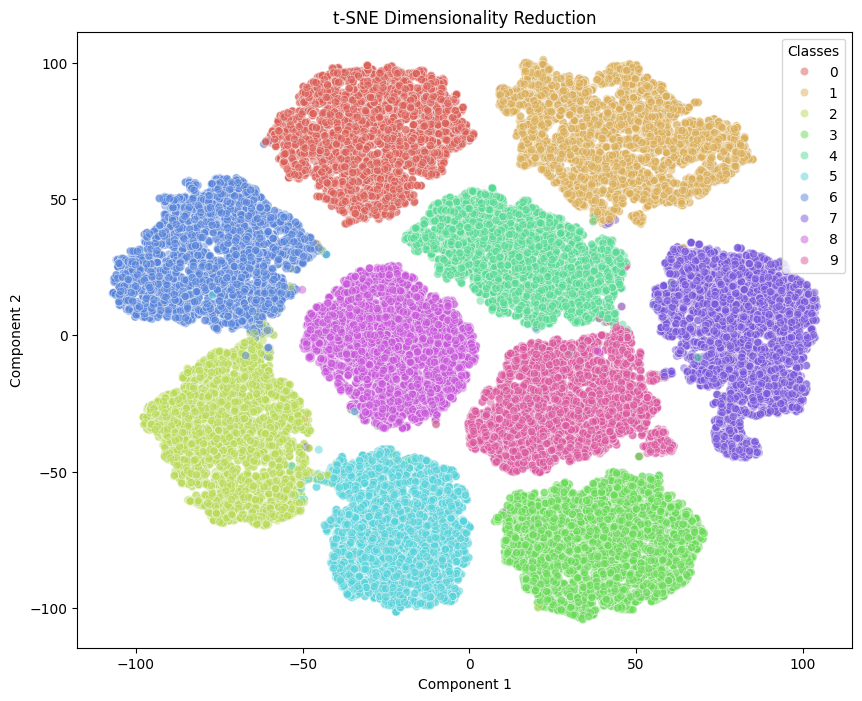

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


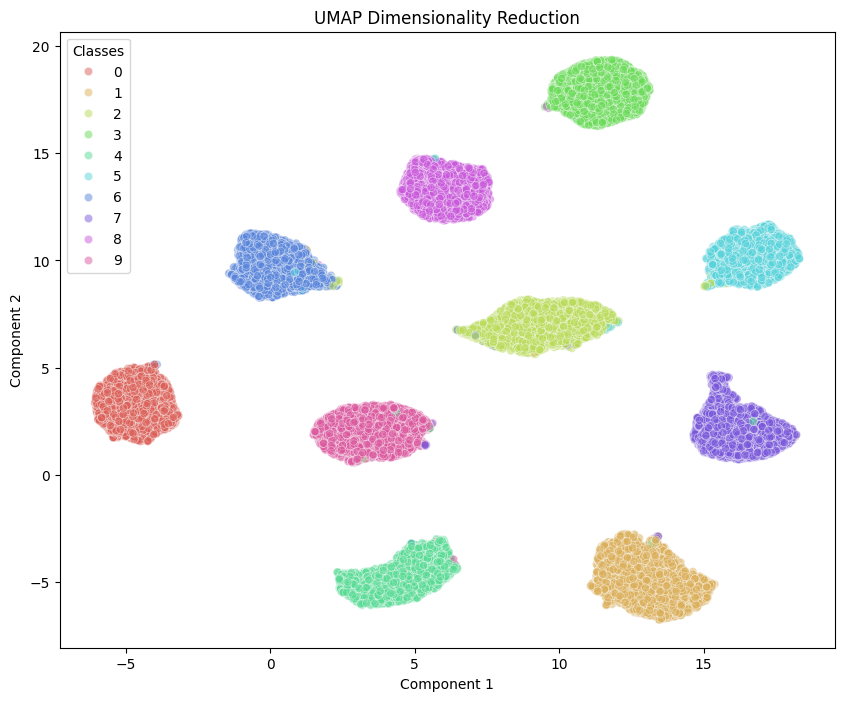

In [ ]:
use_gpu = torch.cuda.is_available()
# Mover el modelo a la GPU si es necesario
if use_gpu:
    model.cuda()

# Obtener embeddings y realizar visualizaciones
def get_embeddings(model, dataloader, use_gpu):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            if use_gpu:
                imgs = imgs.cuda()
            # Process the images through the model layers
            features = model.features(imgs)
            features = model.avgpool(features)
            features = torch.flatten(features, 1)
            features = model.classifier(features)
            embeddings.append(features.cpu())
            labels.append(lbls)

    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels


# Crear un dataloader para todo el conjunto de entrenamiento
full_train_loader = torch.utils.data.DataLoader(
    train_mnist, batch_size=128, shuffle=False, num_workers=2, pin_memory=use_gpu
)

# Obtener las embeddings
embeddings, labels = get_embeddings(model, full_train_loader, use_gpu)
# Convertir embeddings y labels a NumPy arrays
embeddings_np = embeddings.numpy()
labels_np = labels.numpy()

# Visualización con t-SNE (Scikit-learn)
from sklearn.manifold import TSNE

# Configurar t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# Ajustar y transformar las embeddings
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Graficar
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1],
    hue=labels_np, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('t-SNE Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

# Visualización con UMAP
import umap.umap_ as umap

# Configurar UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

# Ajustar y transformar las embeddings
embeddings_umap = umap_reducer.fit_transform(embeddings_np)

# Graficar
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_umap[:, 0], y=embeddings_umap[:, 1],
    hue=labels_np, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()